In [1]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import cv2
import os
from random import shuffle

TRAIN_DIR = '/home/yogeshn/anaconda3/AAI_Project/Data/train'
TEST_DIR = '/home/yogeshn/anaconda3/AAI_Project/Data/test'
IMG_SIZE = 100
LR=0.0001
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6-layer-convolution')


In [2]:
def label_img(img):
    word_label=img.split('.')[-3] #dog.1.png
    if word_label =='cat': return [1,0]
    elif  word_label =='dog': return [0,1]

In [3]:
def create_train_data():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        train_data.append([np.array(img),np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy',train_data)
    return train_data
    

In [4]:
def test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('0')[0]
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    
    np.save('test_data.npy',testing_data)
    return testing_data

In [5]:
training_data = create_train_data()

100%|██████████| 25000/25000 [00:24<00:00, 1004.14it/s]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


import tensorflow as tf
tf.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)



convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



In [7]:
#if os.path.exists('{}.meta'.format(MODEL_NAME)):
#    model.load(MODEL_NAME)
#    print('model loaded!')

In [8]:
train = training_data[:-500]
test = training_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]


In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=6, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 2297  | total loss: 0.43969 | time: 103.265s
| Adam | epoch: 006 | loss: 0.43969 - acc: 0.7992 -- iter: 24448/24500
Training Step: 2298  | total loss: 0.43562 | time: 104.527s
| Adam | epoch: 006 | loss: 0.43562 - acc: 0.8021 | val_loss: 0.48423 - val_acc: 0.7860 -- iter: 24500/24500
--


In [11]:

model.save(MODEL_NAME)

INFO:tensorflow:/home/yogeshn/anaconda3/AAI_Project/dogsvscats-0.0001-6-layer-convolution.model is not in all_model_checkpoint_paths. Manually adding it.


In [12]:
#tensorboard --logdir = /home/yogeshn/anaconda3/log

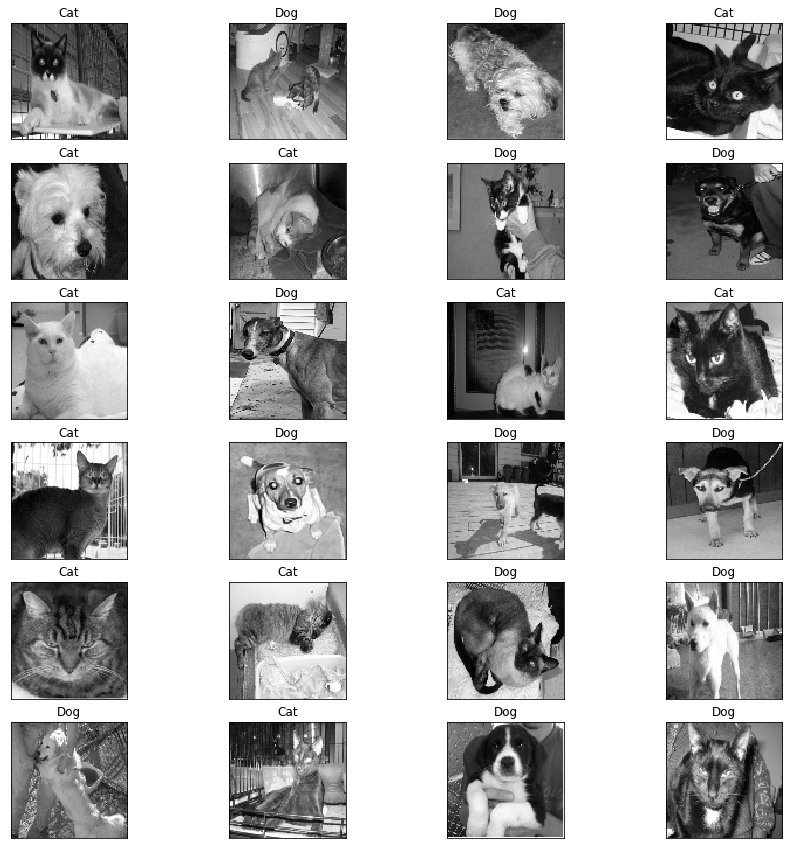

In [13]:
import matplotlib.pyplot as plt


#test_data = np.load('test_data.npy')
test_data=test_data()
fig=plt.figure(figsize=(15,15))

for num,data in enumerate(test_data[:24]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(6,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()